<img src="https://bit.ly/2VnXWr2" width="100" align="left">

# Final project: NLP to predict Myers-Briggs Personality Type

## Imports

In [ ]:
"""
You'll first need to download glove.6B.100d.txt from https://nlp.stanford.edu/projects/glove/ and save it to the following
path (NLP-to-predict-Myers-Briggs-Personality-Type/glove_data/glove.6B/)of your local version of my project's reopsitory
"""

In [1]:
import re
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import math

import pickle as pkl

from sklearn.model_selection import train_test_split

import keras.metrics
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.
C:\Users\Miguel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Miguel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Miguel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Miguel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtype

## 4. Model building and evaluation: Deep Learning

In [2]:
spacy_nlp = spacy.load('en_core_web_sm')

In [3]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove_data/glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

### Using Types

In [5]:
mbti_df_clean = pd.read_pickle("data/output_pickles/mbti_clean_text.pkl")
result_umap_types  = pd.read_csv("data/output_csv/result_umap_types.csv")

In [6]:
mbti_df_clean.head()

,type,posts,type_clean,posts_clean,type_lemma,posts_lemma
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,infj,intj moments sportscenter plays pranks life ch...,infj,intj moment sportscent play prank life change ...
1,entp,'I'm finding the lack of me in these posts ver...,entp,finding lack posts alarming sex boring positio...,entp,find lack post alarming sex bore position exam...
2,intp,'Good one _____ https://www.youtube.com/wat...,intp,good course know blessing curse absolutely pos...,intp,good course know blessing curse absolutely pos...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",intj,dear intp enjoyed conversation day esoteric ga...,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,'You're fired.|||That's another silly misconce...,entj,fired silly misconception approaching logicall...,entj,fire silly misconception approach logically go...


In [7]:
result_umap_types.head()

,Unnamed: 0,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,...,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,0,infj,11.12,135.2900,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3.910143,7.477874
1,1,entp,23.40,187.4756,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.938040,5.939636
2,2,intp,16.72,180.6900,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3.740153,5.486389
3,3,intj,21.28,181.8324,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5.415134,7.452929
4,4,entj,19.34,196.4576,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2.083198,7.512875


In [8]:
neg, pos = np.bincount(result_umap_types["enfj"])
total = neg + pos
print('Total: {}\n    enfj: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["enfp"])
total = neg + pos
print('Total: {}\n    enfp: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["entj"])
total = neg + pos
print('Total: {}\n    entj: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["entp"])
total = neg + pos
print('Total: {}\n    entp: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["esfj"])
total = neg + pos
print('Total: {}\n    esfj: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["esfp"])
total = neg + pos
print('Total: {}\n    esfp: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["estj"])
total = neg + pos
print('Total: {}\n    estj: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["estp"])
total = neg + pos
print('Total: {}\n    estp: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["infj"])
total = neg + pos
print('Total: {}\n    infj: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["infp"])
total = neg + pos
print('Total: {}\n    infp: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["intj"])
total = neg + pos
print('Total: {}\n    intj: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["intp"])
total = neg + pos
print('Total: {}\n    intp: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["isfj"])
total = neg + pos
print('Total: {}\n    isfj: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["isfp"])
total = neg + pos
print('Total: {}\n    isfp: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["istj"])
total = neg + pos
print('Total: {}\n    istj: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_types["istp"])
total = neg + pos
print('Total: {}\n    istp: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Total: 8675
    enfj: 190 (2.19% of total)

Total: 8675
    enfp: 675 (7.78% of total)

Total: 8675
    entj: 231 (2.66% of total)

Total: 8675
    entp: 685 (7.90% of total)

Total: 8675
    esfj: 42 (0.48% of total)

Total: 8675
    esfp: 48 (0.55% of total)

Total: 8675
    estj: 39 (0.45% of total)

Total: 8675
    estp: 89 (1.03% of total)

Total: 8675
    infj: 1470 (16.95% of total)

Total: 8675
    infp: 1832 (21.12% of total)

Total: 8675
    intj: 1091 (12.58% of total)

Total: 8675
    intp: 1304 (15.03% of total)

Total: 8675
    isfj: 166 (1.91% of total)

Total: 8675
    isfp: 271 (3.12% of total)

Total: 8675
    istj: 205 (2.36% of total)

Total: 8675
    istp: 337 (3.88% of total)



In [9]:
labels_dict = {0: 190 , 1: 675, 2: 231, 3: 685, 4: 42, 5: 48, 6: 39, 7: 89, 8: 1470,
                9: 1832, 10: 1091, 11: 1304, 12: 166, 13: 271, 14: 205, 15: 337}

In [10]:
def create_class_weight(labels_dict):
    total = 8675
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

class_weights = create_class_weight(labels_dict)

In [11]:
labels = ["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp", "infj", "infp", "intj", "intp", "isfj", 
          "isfp", "istj", "istp"]
y = result_umap_types[labels].values
X = mbti_df_clean["posts_clean"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940,) (6940, 16) (1735,) (1735, 16)


In [13]:
X_train = list(X_train)

In [14]:
texts = [line for line in X_train] 

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [16]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 90265


In [17]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (6940, 200)
Shape of label tensor: (6940, 16)


In [18]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y_train[indices]

In [19]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

print ((x_train.shape),(y_train.shape),(x_val.shape),(y_val.shape))

(5552, 200) (5552, 16) (1388, 200) (1388, 16)


In [20]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [ 114  454  154  439   27   35   22   60  936 1183  713  794   98  168
  135  220]
validation:  [ 35  96  33 111   8   5  10  14 246 279 185 217  23  50  26  50]


In [21]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [   27   147   128 52220  4434   381  2151  1169    97   194  5629    47
     6   147  5153   434   625   194  9676   654    24    34   283   903
   375    63    64   590  2977   420   129    67  1866  2481  1222   129
   247  4725   248  1199    15  2649  1938   169   624 10832  1675   517
    72  6212   198  1870   147   157   571    20   107    32    79 12752
   115   152  2045    82  6225   189  2179     1    32  2073    16    90
     2  2999   305 11192   256   147    51  2188   122   267  7878    82
  1670  1202  2188  3489  2073    16   551   585   260   295    27  1215
  1970    64  1140  4895   260  1678 38428   464  1464    85   774    74
   705   542 38428    27   283  9881   239 25128   260  1346   260   712
   101  2306  2067   116  1977     6   293  1678   101  2067  7307   260
   712 24744  2000   359     6  4086   292   235 12962   624  6645    54
    75   114    73  3389    48 27969   520   624  2022   624   105 52221
  6645    75   114    73 384

In [22]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="UTF-8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_data/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(16, activation="softmax")(x)

In [25]:
opt = keras.optimizers.Adam()

model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer=opt,
             weighted_metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          9026600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [26]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val), verbose=2, 
                    class_weight=class_weights)
keras.backend.clear_session()

Training progress:
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 5552 samples, validate on 1388 samples
Epoch 1/10
 - 13s - loss: 5.8547 - accuracy: 0.1413 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 2.2851 - val_accuracy: 0.2529 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
 - 13s - loss: 5.6190 - accuracy: 0.2036 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 2.2486 - val_accuracy: 0.2997 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
 - 13s - loss: 5.4052 - accuracy: 0.2424 - precision_1: 0.6712 - recall_1: 0.0047 - val_loss: 2.1033 - val_accuracy: 0.3869 - val_precision_1: 0.7143 - val_recall_1: 0.0036
Epoch 4/10
 - 13s - loss: 5.1426 - accuracy: 0.2789 - precision_1: 0.6541 - recall_1: 0.0222 - val_loss: 2.0161 - val_accuracy: 0.3761 - val_precision_1: 0.6034 - val_recall_1: 0.0504
Epoch 5/10
 - 13s - loss: 4.8447 - accu

In [27]:
hist_df = pd.DataFrame(history.history) 

hist_df.to_csv("data/output_csv/types_hist_df.csv")

In [28]:
types_hist_df = pd.read_csv("data/output_csv/types_hist_df.csv")
types_hist_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [29]:
types_hist_df['val_f1'] = ((types_hist_df["val_precision_1"]*types_hist_df["val_recall_1"])/
                           (types_hist_df["val_precision_1"]+types_hist_df["val_recall_1"]))

In [30]:
types_hist_df = types_hist_df[['val_loss', 'loss', 'val_accuracy', 'accuracy', 'val_precision_1', 'precision_1',
                  'val_recall_1', 'recall_1', 'val_f1']]
types_hist_df

,val_loss,loss,val_accuracy,accuracy,val_precision_1,precision_1,val_recall_1,recall_1,val_f1
0,2.285122,5.854738,0.252882,0.141347,0.000000,0.000000,0.000000,0.000000,NaN
1,2.248610,5.619026,0.299712,0.203618,0.000000,0.000000,0.000000,0.000000,NaN
2,2.103251,5.405204,0.386888,0.242368,0.714286,0.671247,0.003602,0.004749,0.003584
3,2.016147,5.142599,0.376081,0.278860,0.603448,0.654125,0.050432,0.022229,0.046543
4,1.904330,4.844652,0.451009,0.345077,0.719212,0.698353,0.105187,0.056147,0.091766
5,1.803093,4.513499,0.471182,0.387046,0.725352,0.681921,0.148415,0.113993,0.123206
6,1.777016,4.287656,0.462536,0.415177,0.684636,0.671154,0.182997,0.160014,0.144400
7,1.724843,4.101380,0.474063,0.437199,0.723881,0.694416,0.209654,0.201708,0.162570
8,1.689161,3.896417,0.481268,0.457848,0.683946,0.720135,0.294669,0.229980,0.205942
9,1.750420,3.729943,0.468300,0.489933,0.705596,0.728107,0.208934,0.253802,0.161201


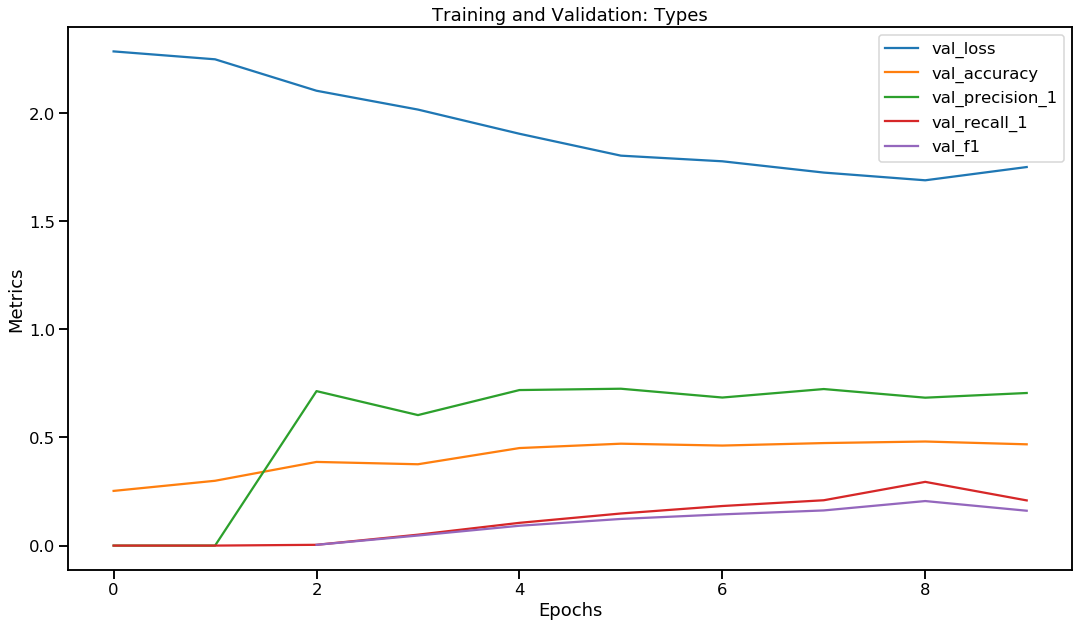

In [60]:
plt.figure(figsize=(18,10))
plt.plot(types_hist_df[['val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1']])

plt.title('Training and Validation: Types')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1'])
plt.savefig("images/output_images/types_history.png")

sns.set_context("talk")
plt.show()

### Using dimensions

<img src="https://www.nicepng.com/png/detail/148-1486992_discover-the-most-powerful-ways-to-automate-your.png" width="1000"> 

In [32]:
#raise SystemExit("Here it comes another quite consuming memory process. You should better not start it till everything else has itereated propperly")

In [88]:
mbti_df_clean = pd.read_pickle("data/output_pickles/mbti_clean_text.pkl")
result_umap_dimensions  = pd.read_csv("data/output_csv/result_umap_dimensions.csv")

In [89]:
mbti_df_clean.head()

,type,posts,type_clean,posts_clean,type_lemma,posts_lemma
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,infj,intj moments sportscenter plays pranks life ch...,infj,intj moment sportscent play prank life change ...
1,entp,'I'm finding the lack of me in these posts ver...,entp,finding lack posts alarming sex boring positio...,entp,find lack post alarming sex bore position exam...
2,intp,'Good one _____ https://www.youtube.com/wat...,intp,good course know blessing curse absolutely pos...,intp,good course know blessing curse absolutely pos...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",intj,dear intp enjoyed conversation day esoteric ga...,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,'You're fired.|||That's another silly misconce...,entj,fired silly misconception approaching logicall...,entj,fire silly misconception approach logically go...


In [90]:
result_umap_dimensions.head()

,Unnamed: 0,type,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1
0,0,infj,11.12,135.2900,0,0,1,0,3.910143,7.477874
1,1,entp,23.40,187.4756,1,0,0,1,3.938040,5.939636
2,2,intp,16.72,180.6900,0,0,0,1,3.740153,5.486389
3,3,intj,21.28,181.8324,0,0,0,0,5.415134,7.452929
4,4,entj,19.34,196.4576,1,0,0,0,2.083198,7.512875


In [91]:
neg, pos = np.bincount(result_umap_dimensions["i-e"])
total = neg + pos
print('Total: {}\n    i-e: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_dimensions["n-s"])
total = neg + pos
print('Total: {}\n    n-s: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_dimensions["t-f"])
total = neg + pos
print('Total: {}\n    t-f: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

neg, pos = np.bincount(result_umap_dimensions["j-p"])
total = neg + pos
print('Total: {}\n    j-p: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))


Total: 8675
    i-e: 1999 (23.04% of total)

Total: 8675
    n-s: 1197 (13.80% of total)

Total: 8675
    t-f: 4694 (54.11% of total)

Total: 8675
    j-p: 5241 (60.41% of total)



In [92]:
labels_dict = {0: 1999 , 1: 1997, 2: 4694, 3: 5241}

In [93]:
def create_class_weight(labels_dict):
    total = 8675
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

class_weights = create_class_weight(labels_dict)

In [94]:
labels = ["i-e", "n-s", "t-f", "j-p"]
y = result_umap_dimensions[labels].values
X = mbti_df_clean["posts_clean"]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940,) (6940, 4) (1735,) (1735, 4)


In [96]:
X_train = list(X_train)

In [97]:
texts = [line for line in X_train] 

In [98]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [99]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 90265


In [100]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (6940, 200)
Shape of label tensor: (6940, 4)


In [101]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y_train[indices]

In [102]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

print ((x_train.shape),(y_train.shape),(x_val.shape),(y_val.shape))

(5552, 200) (5552, 4) (1388, 200) (1388, 4)


In [103]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [1282  742 3006 3320]
validation:  [335 209 751 855]


In [104]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 1736 10502     7  1866   605 47533 11675  1425  4519  8340 30511 36246
  7671 47534   649  3036  4311   905  3649  2954   141  7925  4052    53
   169  3126    69   466 24122  1959 47535   110  6761  4717  1567    29
   252   399   193    10  3296    38   578     9   496    62    21  2417
 13342  1688   111 14375   751 47536 47537  1314 24123    77  4053  4224
 26729   856    86  2195  1937  4583  8679 30512    21   673  5703  5065
    59   258 47538   649   285 10503 17195  1423 10249  1051   366    49
 47539  1346  4801   886  1871   321  5318 12071   752  1944   781  4433
    84  5943  3312   331  2320   545   583  1828   741    45  2126    10
  1102   659    10  4669 36247  4626  7151 47540 30512    37   509  1125
     5 15640 15641  1930  8059   504 13825   540   274  1309  3190  2536
  2964  1035  2062 17196   234  2221   685   771   581  4225 10504     5
    47  3368  6007  3414  2574  1860   251  1068    31    49  1140   786
 10760  1847   114     4    

In [105]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="UTF-8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_data/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [106]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [107]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(4, activation="softmax")(x)

In [108]:
opt = keras.optimizers.Adam()

model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer=opt,
             weighted_metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          9026600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [109]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 5, batch_size=32, validation_data=(x_val, y_val), verbose=2, 
                    class_weight=class_weights)
keras.backend.clear_session()

Training progress:
Train on 5552 samples, validate on 1388 samples
Epoch 1/5
 - 14s - loss: 2.3956 - accuracy: 0.1664 - precision_1: 0.7762 - recall_1: 6.7079e-04 - val_loss: 1.9356 - val_accuracy: 0.1419 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/5
 - 14s - loss: 2.3597 - accuracy: 0.2084 - precision_1: 0.8412 - recall_1: 0.0038 - val_loss: 1.8989 - val_accuracy: 0.3062 - val_precision_1: 1.0000 - val_recall_1: 9.3023e-04
Epoch 3/5
 - 14s - loss: 2.2972 - accuracy: 0.2632 - precision_1: 0.7968 - recall_1: 0.0456 - val_loss: 1.8426 - val_accuracy: 0.3970 - val_precision_1: 0.9157 - val_recall_1: 0.0758
Epoch 4/5
 - 14s - loss: 2.2419 - accuracy: 0.3052 - precision_1: 0.7921 - recall_1: 0.0802 - val_loss: 1.7943 - val_accuracy: 0.3581 - val_precision_1: 0.7938 - val_recall_1: 0.1558
Epoch 5/5
 - 14s - loss: 2.1851 - accuracy: 0.3367 - precision_1: 0.7638 - recall_1: 0.1292 - val_loss: 1.7722 - val_accuracy: 0.4071 - val_precision_1: 0.8297 - val_recall_1: 0.1223


In [115]:
hist_df = pd.DataFrame(history.history) 

hist_df.to_csv("data/output_csv/dimensions_hist_df.csv")

In [116]:
dimensions_hist_df = pd.read_csv("data/output_csv/dimensions_hist_df.csv")
dimensions_hist_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [117]:
dimensions_hist_df

,val_loss,val_accuracy,val_precision_1,val_recall_1,loss,accuracy,precision_1,recall_1
0,1.935583,0.141931,0.000000,0.000000,2.395565,0.166433,0.776176,0.000671
1,1.898879,0.306196,1.000000,0.000930,2.359707,0.208440,0.841181,0.003793
2,1.842561,0.396974,0.915730,0.075814,2.297188,0.263161,0.796757,0.045606
3,1.794269,0.358069,0.793839,0.155814,2.241864,0.305215,0.792060,0.080195
4,1.772235,0.407061,0.829653,0.122326,2.185081,0.336719,0.763816,0.129205


In [118]:
dimensions_hist_df['val_f1'] = ((dimensions_hist_df["val_precision_1"]*dimensions_hist_df["val_recall_1"])/
                                (dimensions_hist_df["val_precision_1"]+dimensions_hist_df["val_recall_1"]))

In [119]:
dimensions_hist_df = dimensions_hist_df[['val_loss', 'loss', 'val_accuracy', 'accuracy', 'val_precision_1', 'precision_1',
                  'val_recall_1', 'recall_1', 'val_f1']]
dimensions_hist_df

,val_loss,loss,val_accuracy,accuracy,val_precision_1,precision_1,val_recall_1,recall_1,val_f1
0,1.935583,2.395565,0.141931,0.166433,0.000000,0.776176,0.000000,0.000671,NaN
1,1.898879,2.359707,0.306196,0.208440,1.000000,0.841181,0.000930,0.003793,0.000929
2,1.842561,2.297188,0.396974,0.263161,0.915730,0.796757,0.075814,0.045606,0.070017
3,1.794269,2.241864,0.358069,0.305215,0.793839,0.792060,0.155814,0.080195,0.130249
4,1.772235,2.185081,0.407061,0.336719,0.829653,0.763816,0.122326,0.129205,0.106607


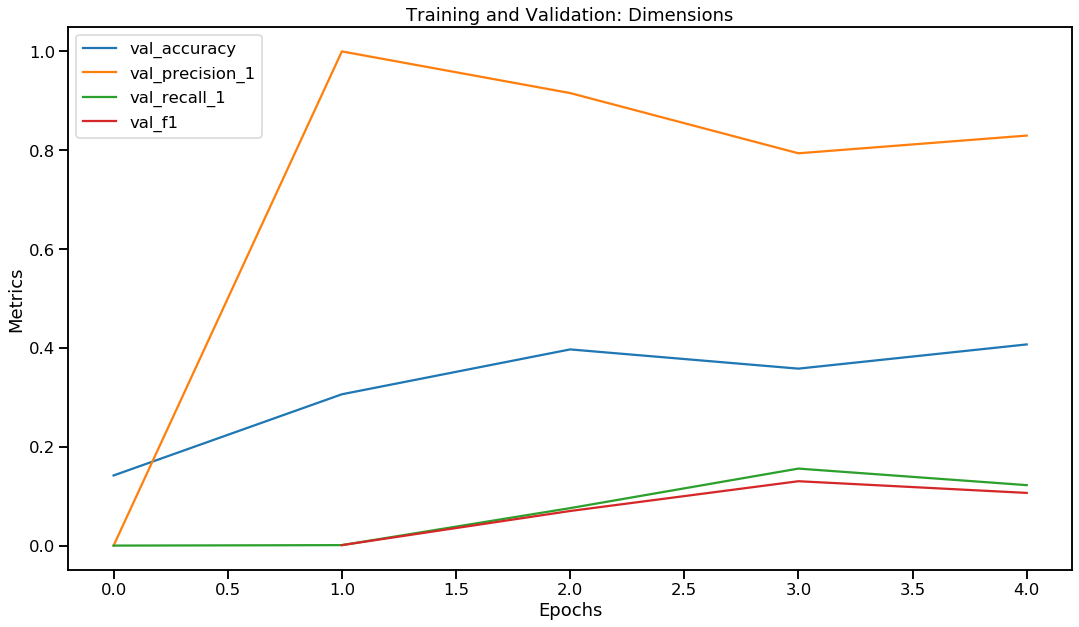

In [120]:
plt.figure(figsize=(18,10))
plt.plot(dimensions_hist_df[['val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1']])

plt.title('Training and Validation: Dimensions')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1'])
plt.savefig("images/output_images/dimensions_history.png")

sns.set_context("talk")
plt.show()

#### Comments

Best F1 Scores for both models, the one using types and the one using dimensions are of 0.205942 and 0.130249 respectively, still much lower than the scores obtained using ML models.